In [4]:
#| code-fold: true
#| code-summary: "Ensure faiss-gpu is correctly installed"

import faiss
hasattr(faiss, "StandardGpuResources")

True

In [45]:
#| code-fold: true
#| code-summary: "Show imports"
from datasets import load_dataset
import matplotlib.pyplot as plt

from colbert.data import Queries
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Searcher

import matplotlib.pyplot as plt
import numpy
import torch
import json
import tqdm
import glob
import re
import pytrec_eval
import pickle

In [ ]:
#| code-fold: true
#| code-summary: "Show indexing + memory profiling script"

import colbert
from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection
from datasets import load_dataset
import threading
import time
import psutil
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse 
import pynvml

def memory_monitor(stop_event, cpu_readings, gpu_readings):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    
    while not stop_event.is_set():
        mem_cpu = psutil.Process().memory_info().rss / 1024 / 1024 / 1024
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        mem_gpu = info.used / 1024 / 1024 / 1024
        
        cpu_readings.append((datetime.now(), mem_cpu))
        gpu_readings.append((datetime.now(), mem_gpu))
        time.sleep(5)

def log_memory(index_name, passages):
    stop_event = threading.Event()
    cpu_readings = []
    gpu_readings = []
    monitor_thread = threading.Thread(target=memory_monitor, args=(stop_event, cpu_readings, gpu_readings))
    monitor_thread.start()

    try:
        with Run().context(RunConfig(nranks=1, rank=0)):
            config = ColBERTConfig(
                doc_maxlen=220,
                nbits=2,
                dim=96,
                kmeans_niters=4,
                index_bsize=32,
                bsize=64,
                checkpoint="answerdotai/answerai-colbert-small-v1",
                avoid_fork_if_possible=True
            )
        
            indexer = Indexer(checkpoint="answerdotai/answerai-colbert-small-v1", config=config)
            index_path = indexer.index(name=index_name, collection=passages["text"], overwrite=True)
    finally:
        stop_event.set()
        monitor_thread.join()
    
    return cpu_readings, gpu_readings

def main():
    parser = argparse.ArgumentParser(description='fp')
    parser.add_argument('--fp', type=str, default="fp32", help='Floating point precision used')
    args = parser.parse_args()
    fp = args.fp
        
    dataset_name = "ConditionalQA"
    index_name = f'ColBERT_{dataset_name}_{fp}'
    passages = load_dataset("UKPLab/dapr", f"{dataset_name}-corpus", split="test")

    cpu_readings, gpu_readings = log_memory(index_name, passages)

    # CPU RAM artifacts
    start_time = cpu_readings[0][0]
    index = [(t - start_time).total_seconds() for t, _ in cpu_readings]
    cpu_readings = pd.Series([mem for _, mem in cpu_readings], index=index, name="mem_gb" )
    cpu_readings.index.name = "time_secs"
    cpu_readings.plot(title=f'ColBERT CPU RAM ({fp})', xlabel='Time (sec)', ylabel='Memory (GB)')
    plt.tight_layout()
    plt.savefig(f'colbert_{fp}_cpu_readings.png')
    plt.close()
    cpu_readings.to_csv(f"colbert_{fp}_cpu_readings.csv")

    # GPU RAM artifacts
    start_time = gpu_readings[0][0]
    index = [(t - start_time).total_seconds() for t, _ in gpu_readings]
    gpu_readings = pd.Series([mem for _, mem in gpu_readings], index=index, name="mem_gb" )
    gpu_readings.index.name = "time_secs"
    gpu_readings.plot(title=f'ColBERT GPU RAM ({fp})', xlabel='Time (sec)', ylabel='Memory (GB)')
    plt.tight_layout()
    plt.savefig(f'colbert_{fp}_gpu_readings.png')
    plt.close()
    gpu_readings.to_csv(f"colbert_{fp}_gpu_readings.csv")

if __name__ == "__main__":
    main()

In [ ]:
#| code-fold: true
#| code-summary: "Show Recall calculation script"

from datasets import load_dataset
import matplotlib.pyplot as plt

from colbert.data import Queries
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Searcher

import matplotlib.pyplot as plt
import numpy
import torch
import json
import tqdm
import glob
import re
import pytrec_eval
import argparse 
import pickle

def get_qrels(qrels_rows):
    qrels = {}
    for qrel_row in qrels_rows:
        qid = qrel_row["query_id"]
        pid = qrel_row["corpus_id"]
        rel = qrel_row["score"]
        qrels.setdefault(qid, {})
        qrels[qid][pid] = rel
    
    return qrels

def _recall(qrels, res):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, {'recall.10'})
    metrics = evaluator.evaluate(res)
    assert len(metrics) == len(set(qrels_rows["query_id"]))

    mean_recall = sum(metrics[qid]['recall_10'] for qid in metrics.keys()) / len(metrics)
    return mean_recall


dataset_name = "ConditionalQA"
queries = load_dataset("UKPLab/dapr", f"{dataset_name}-queries", split="test")
passages = load_dataset("UKPLab/dapr", f"{dataset_name}-corpus", split="test")
qrels_rows = load_dataset("UKPLab/dapr", f"{dataset_name}-qrels", split="test")
qrels = get_qrels(qrels_rows)
print(dataset_name)

queries_dict = {}
for item in queries: queries_dict[item['_id']] = item['text']

def main():
    parser = argparse.ArgumentParser(description='index')
    parser.add_argument('--index', type=str, default="", help='Index name')
    args = parser.parse_args()
    index = args.index
    
    with Run().context(RunConfig(nranks=1)):
        searcher = Searcher(
            index=index,
            config=ColBERTConfig(
                    ncells=4,
                    centroid_score_threshold=0.45,
                    ndocs=1024
                )
        )
    
        _queries = Queries(data=queries_dict)
        ranking = searcher.search_all(_queries, k=10)

    colbert_results = {}

    for qid in ranking.todict().keys():
        colbert_scores = ranking.todict()[qid]
        colbert_results[qid] = {passages[idx]['_id']: score for idx, _, score in colbert_scores}

    with open(f"colbert_results_{index.split('_')[-1]}.pkl", 'wb') as file: pickle.dump(colbert_results, file)
    print(_recall(qrels, colbert_results))

if __name__ == "__main__":
    main()

## Background

I ran an experiment to explore the differences between FP32 full precision and mixed precision in ColBERT indexing and retrieval. This was purely a curiosity-driven exploration - not claiming this is best practice, just wanted to see if there were any differences. This notebook shares my findings. I use the [UKPLab/DAPR ConditionalQA dataset](https://huggingface.co/datasets/UKPLab/dapr/viewer/ConditionalQA-docs) for this exercise.

**What I did:**

- Created [a fork of ColBERT](https://github.com/vishalbakshi/ColBERT/commits/mixed_precision_false/) and turned off all mixed precision conversions
- Used Claude and ChatGPT to help identify all the places that needed changes (including CUDA kernels)
- Ran indexing experiments on the UKPLab's ConditionalQA dataset (70k documents)
- Tracked memory usage during indexing (see script above)
- Compared recall performance and retrieved passages (see script above)
- Analyzed the resulting index artifacts

**Key findings:**

- Mixed precision took 2.5x longer to index (180s vs 70s) - wasn't expecting that
- Mixed precision used slightly more GPU memory, full precision used more CPU memory
- Full precision gave a tiny 0.3% recall boost (basically negligible)
- 14% of retrieved passages were different between the two approaches
- The centroids created during indexing were significantly different
- Different mappings between passage IDs and centroids

<iframe width="560" height="315" src="https://www.youtube.com/embed/aiNQ4I8YaD0?si=OKvaUtumf7q1qGYf" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Indexing Time

I was surprised to see that using mixed precision resulted in a much longer indexing time. I wonder if that would still hold over multiple iterations of indexing.

|Precision|Indexing Time (seconds)|
|:-:|:-:|
|fp32|70
|amp|180

## Maximum Memory Usage

Another surprise---mixed precision actually uses _more_ GPU memory than full precision.

|Precision|Max GPU Mem (GB)|Max CPU Mem (GB)
|:-:|:-:|:-:|
|fp32|5.51|0.824
|amp|5.78|0.814

## Recall@10

The differences in Recall@10 is negligible, the full precision index has a slight advantage.

fp32: 0.13034885692197787

amp: 0.1299388528219369

In [44]:
(0.13034885692197787 - 0.1299388528219369)/0.1299388528219369

0.003155361857802613

## Comparing Retrieved Passages and Scores

Out of the 2710 total passages retrieved, 388 passages were retrieved using one index but not the other---that's about a 14% difference in retrieved passages due to a difference in precision.

In [49]:
with open('colbert_results_fp32.pkl', 'rb') as file: colbert_results_fp32 = pickle.load(file)
with open('colbert_results_amp.pkl', 'rb') as file: colbert_results_amp = pickle.load(file)

In [51]:
colbert_results_fp32.keys() == colbert_results_amp.keys()

True

In [53]:
colbert_results_fp32['dev-0']

{'265-59': 29.345699310302734,
 '8-116': 29.341297149658203,
 '8-118': 29.336307525634766,
 '8-67': 29.32498550415039,
 '8-9': 29.2913875579834,
 '8-70': 29.290199279785156,
 '270-51': 29.28421401977539,
 '40-29': 29.28375244140625,
 '107-110': 29.282079696655273,
 '459-115': 29.28005599975586}

In [58]:
n_diffs = 0
for qid, fp32_res in colbert_results_fp32.items():
    for pid in fp32_res.keys():
        if pid not in colbert_results_amp[qid].keys(): 
            n_diffs += 1
 
for qid, amp_res in colbert_results_amp.items():
    for pid in amp_res.keys():
        if pid not in colbert_results_fp32[qid].keys(): 
            n_diffs += 1

n_diffs

388

In [60]:
n_diffs/(271*10)

0.14317343173431735

In [61]:
colbert_results_fp32['dev-0']

{'265-59': 29.345699310302734,
 '8-116': 29.341297149658203,
 '8-118': 29.336307525634766,
 '8-67': 29.32498550415039,
 '8-9': 29.2913875579834,
 '8-70': 29.290199279785156,
 '270-51': 29.28421401977539,
 '40-29': 29.28375244140625,
 '107-110': 29.282079696655273,
 '459-115': 29.28005599975586}

Overall, the full precision index results in a slightly lower retrieved passage score.

In [64]:
total_amp_score = 0
for qid, amp_res in colbert_results_amp.items():
    for score in amp_res.values(): total_amp_score += score
total_amp_score

80438.375

In [66]:
total_fp32_score = 0
for qid, fp32_res in colbert_results_fp32.items():
    for score in fp32_res.values(): total_fp32_score += score
total_fp32_score

80435.61682701111

## Comparing Index Artifacts

In [15]:
colbert_fp32_root = "./experiments/default/indexes/ColBERT_ConditionalQA_fp32"
colbert_amp_root  = "./experiments/default/indexes/ColBERT_ConditionalQA_amp"

### metadata.json

Both indexes (full precision and mixed precision) produce the same metadata.json.

In [16]:
params = [
    "index_bsize",
    "nbits",
    "kmeans_niters",
    "dim",
    "rank",
    "gpus",
    "nranks",
    "num_chunks",
    "num_partitions",
    "num_embeddings",
    "avg_doclen"
    ]

In [17]:
with open(f"{colbert_fp32_root}/metadata.json", 'r') as f: colbert_fp32_metadata = json.load(f)
with open(f"{colbert_amp_root}/metadata.json", 'r') as f: colbert_amp_metadata = json.load(f)

In [18]:
for p in params:
    if p not in ["num_chunks", "num_partitions", "num_embeddings", "avg_doclen"]: assert colbert_fp32_metadata['config'][p] == colbert_amp_metadata['config'][p], p
    elif p == "avg_doclen": assert (colbert_fp32_metadata[p] - colbert_amp_metadata[p]) < 1e-7
    else: assert colbert_fp32_metadata[p] == colbert_amp_metadata[p], p

### centroids.pt

There is a significant difference in centroids---meaning that the sampled document token embeddings and their clusters are different based on the type of precision used.

In [19]:
colbert_fp32_centroids = torch.load(f"{colbert_fp32_root}/centroids.pt")
colbert_amp_centroids = torch.load(f"{colbert_amp_root}/centroids.pt")

In [22]:
torch.allclose(colbert_fp32_centroids, colbert_amp_centroids.float())

False

In [23]:
torch.allclose(colbert_fp32_centroids.half(), colbert_amp_centroids)

False

In [27]:
torch.allclose(colbert_fp32_centroids, colbert_amp_centroids.float(), atol=1e-0)

True

In [29]:
colbert_fp32_centroids.flatten().shape, colbert_amp_centroids.flatten().shape

(torch.Size([1572864]), torch.Size([1572864]))

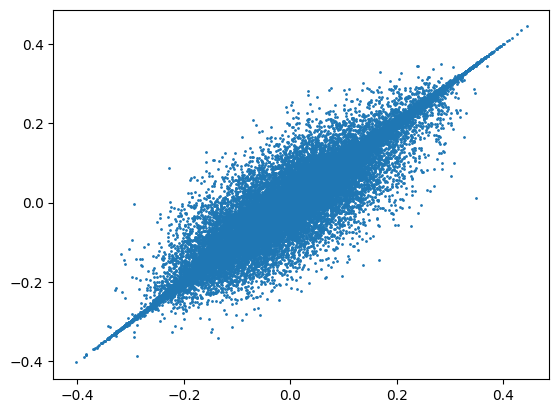

In [33]:
plt.scatter(colbert_fp32_centroids.flatten().cpu().numpy(), colbert_amp_centroids.flatten().cpu().numpy(), s=1);

### ivf.pid.pt

Finally, there is a difference in mappings between passages IDs and centroid IDs. Interestingly, mixed precision results in more passage IDs mapped to centroids.

In [34]:
colbert_fp32_ivf = torch.load(f"{colbert_fp32_root}/ivf.pid.pt")
colbert_amp_ivf  = torch.load(f"{colbert_amp_root}/ivf.pid.pt")

In [35]:
colbert_fp32_ivf[0].shape, colbert_amp_ivf[0].shape

(torch.Size([963143]), torch.Size([975457]))

In [41]:
colbert_amp_ivf[0].shape[0]-colbert_fp32_ivf[0].shape[0]

12314

In [36]:
colbert_fp32_ivf[1].shape, colbert_amp_ivf[1].shape

(torch.Size([16384]), torch.Size([16384]))

## Closing Thoughts

This is just one small dataset with short documents (avg 15 tokens). Sample size of one. I also might have missed some precision conversions in my implementation. Don't take this as definitive - just an interesting exploration of how precision affects the ColBERT pipeline. Here's a summary again of my key findings:

- Mixed precision took 2.5x longer to index (180s vs 70s) - wasn't expecting that
- Mixed precision used slightly more GPU memory, full precision used more CPU memory
- Full precision gave a tiny 0.3% recall boost (basically negligible)
- 14% of retrieved passages were different between the two approaches
- The centroids created during indexing were significantly different
- Different mappings between passage IDs and centroids